Conv1D

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

2024-04-01 18:36:11.411485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 18:36:11.411580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 18:36:11.585835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [3]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, sequence_length, num_channels) = input_shape

        # Scale the sequence_length with respect to the strides.
        sequence_length = sequence_length // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling1D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv1D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv1D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                sequence_length,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                sequence_length,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(sequence_length, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, L, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, L, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Expand dimensions of input tensor for extract_patches.
        # B, L, C -> B, L, C, 1
        x_expanded = tf.expand_dims(x, axis=-1)

        # Extract input patches.
        input_patches = tf.image.extract_patches(
            images=x_expanded,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, L, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, L, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, L, C//G, G
        output = tf.reduce_sum(output, axis=2)

        # Reshape the output kernel.
        # B, L, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

INV+CONV with batchnorm

In [5]:
#Jan 28 2024
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

df_train = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [6]:

def residual_block(x, filters, kernel_size, block_num):
    # Involution block 1
    bn_1 = tf.keras.layers.BatchNormalization()(x)
    relu_1 = tf.keras.layers.Activation('relu')(bn_1)
    inv_1,_ = Involution(channel=1, group_number=1, kernel_size=kernel_size, stride=1, reduction_ratio=1, name=f"inv-{block_num}-1")(relu_1)
    
    #only skip connection
    skip_only = x 
    
    #conv 1x1 into the inner skip_connection
    conv_res_inner = tf.keras.layers.Conv1D(filters, 1, padding='same', name=f"conv_1_1-{block_num}-1")(inv_1)
    
    # Involution block 2
    bn_2 = tf.keras.layers.BatchNormalization()(inv_1)
    relu_2 = tf.keras.layers.Activation('relu')(bn_2)
    inv_2,_ = Involution(channel=1, group_number=1, kernel_size=kernel_size, stride=1, reduction_ratio=1, name=f"inv-{block_num}-2")(relu_2)
    
    #inner residual connection
    skip_connection_1 = tf.keras.layers.Add()([conv_res_inner, inv_2])
    
    #Involution block 3
    bn_3 = tf.keras.layers.BatchNormalization()(skip_connection_1)
    relu_3 = tf.keras.layers.Activation('relu')(bn_3)
    inv_3,_ = Involution(channel=1, group_number=1, kernel_size=kernel_size, stride=1, reduction_ratio=1, name=f"inv-{block_num}-3")(relu_3)
    
    
    conv_res = tf.keras.layers.Conv1D(filters, 1, padding='same', name=f"conv-{block_num}-res")(x)

    # Skip connection
    skip_connection_2 = tf.keras.layers.Add()([conv_res, inv_3, skip_only])

    # Pooling layer
    pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(skip_connection_2)

    return pool

input_layer = tf.keras.layers.Input(shape = (187, 1))

#Convolution laye3
convolution = tf.keras.layers.Convolution1D(32, kernel_size = 3, padding = 'same')(input_layer)
bn = tf.keras.layers.BatchNormalization()(convolution)

# 5 residual block
for block_num in range(5):
    bn = residual_block(bn, filters=32, kernel_size=3, block_num=block_num)
#Fully connected layers
conv_1_1 = tf.keras.layers.Conv1D(32, 1, padding='same')(bn)
BN = tf.keras.layers.BatchNormalization()(conv_1_1)
Relu = tf.keras.layers.Activation('relu')(BN)
glob = tf.keras.layers.GlobalAveragePooling1D()(Relu)
flatten = tf.keras.layers.Flatten()(glob)
fc1 = tf.keras.layers.Dense(128)(flatten)
relu_fc_1 = tf.keras.layers.Activation('relu')(fc1)

num_classes = 5
fc_2 = tf.keras.layers.Dense(num_classes)(relu_fc_1)
output_layer = tf.keras.layers.Activation('softmax')(fc_2)

model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                        beta_1 = 0.9,
                                        beta_2 = 0.999),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

file_path = "model.keras"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

history = model.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 32)   │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inv-0-1             │ [(None, 187, 32), │         55 │ activation[0][0]  │
│ (Involution)        │ (None, 187, 9, 1, │            │                   │
│                     │ 1)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ inv-0-1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_1-0-1        │ (None, 187, 32)   │      1,056 │ inv-0-1[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inv-0-2             │ [(None, 187, 32), │         55 │ activation_1[0][… │
│ (Involution)        │ (None, 187, 9, 1, │            │                   │
│                     │ 1)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 32)   │          0 │ conv_1_1-0-1[0][… │
│                     │                   │            │ inv-0-2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv-0-res (Conv1D) │ (None, 187, 32)   │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inv-0-3             │ [(None, 187, 32), │         55 │ activation_2[0][… │
│ (Involution)        │ (None, 187, 9, 1, │            │                   │
│                     │ 1)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 187, 32)   │          0 │ conv-0-res[0][0], │
│                     │                   │            │ inv-0-3[0][0],    │
│                     │                   │            │ batch_normalizat

 Total params: 19,614 (76.62 KB)

 Trainable params: 18,496 (72.25 KB)

 Non-trainable params: 1,118 (4.37 KB)

Epoch 1/1000


I0000 00:00:1711996644.390799      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.95101, saving model to model.keras
2463/2463 - 105s - 43ms/step - accuracy: 0.9292 - loss: 0.2520 - val_accuracy: 0.9510 - val_loss: 0.1793 - learning_rate: 0.0010
Epoch 2/1000

Epoch 2: val_accuracy did not improve from 0.95101
2463/2463 - 31s - 13ms/step - accuracy: 0.9606 - loss: 0.1425 - val_accuracy: 0.8812 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 3/1000

Epoch 3: val_accuracy did not improve from 0.95101
2463/2463 - 31s - 13ms/step - accuracy: 0.9687 - loss: 0.1157 - val_accuracy: 0.9292 - val_loss: 0.2542 - learning_rate: 0.0010
Epoch 4/1000

Epoch 4: val_accuracy improved from 0.95101 to 0.96757, saving model to model.keras
2463/2463 - 32s - 13ms/step - accuracy: 0.9724 - loss: 0.1017 - val_accuracy: 0.9676 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 5/1000

Epoch 5: val_accuracy did not improve from 0.96757
2463/2463 - 31s - 13ms/step - accuracy: 0.9750 - loss: 0.0924 - val_accuracy: 0.9535 - val_loss: 0.1476 - learni

CONV + INV + batchnorm

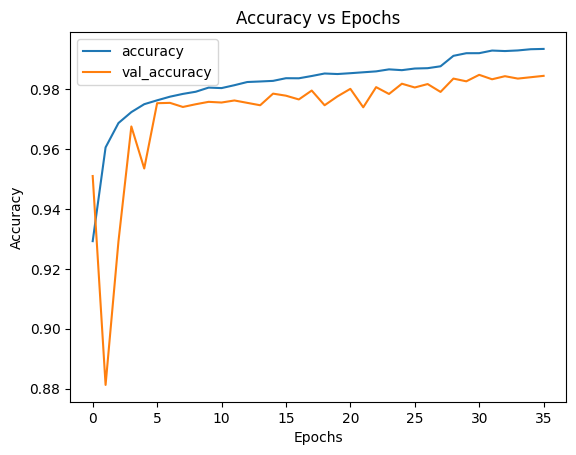

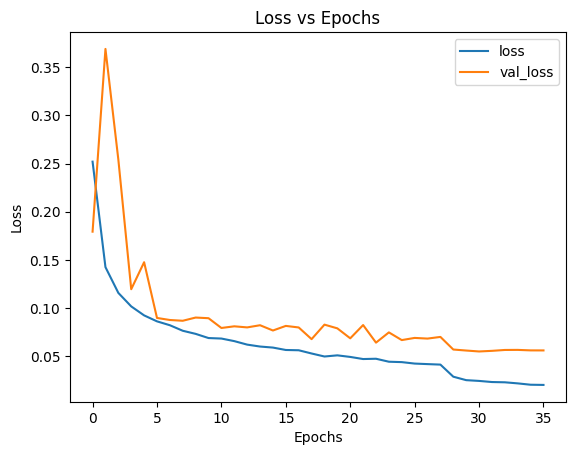

In [8]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [9]:
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average = 'weighted')

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
Test f1 score : 0.9848693294519352 
Test accuracy score : 0.9853827882331445 


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming Y_test and y_pred are 1D arrays
Y_test_2d = Y_test.reshape(-1, 1)
y_pred_2d = pred_test.reshape(-1, 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test_2d, y_pred_2d)

# # Rest of your plotting code
# plt.figure(figsize=(6, 6))
# plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True,
#                       title='Confusion matrix, with normalization')
# plt.title("Confusion_matrix_for-valid : train = 0.2 : 0.8")
# plt.show()


In [ ]:
# import itertools
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):

#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)


#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


In [10]:
from sklearn.metrics import confusion_matrix

# Assuming Y_test and y_pred are 1D arrays
Y_test_2d = Y_test.reshape(-1, 1)
y_pred_2d = pred_test.reshape(-1, 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test_2d, y_pred_2d)

# # Rest of your plotting code
# plt.figure(figsize=(6, 6))
# plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True,
#                       title='Confusion matrix, with normalization')
# plt.title("Confusion_matrix_for-valid : train = 0.2 : 0.8")
# plt.show()


In [11]:
cnf_matrix = confusion_matrix(Y_test_2d, y_pred_2d)
cnf_matrix # batchnorm everywhere


array([[18056,    33,    20,     2,     7],
       [  132,   415,     9,     0,     0],
       [   34,     5,  1391,    13,     5],
       [   24,     0,    17,   121,     0],
       [   17,     0,     2,     0,  1589]])

In [12]:
import numpy as np

# Confusion matrix
cm = np.array(cnf_matrix)

# Initialize list to store results
res = []

# Loop over each class
for c in range(5):
    tp = cm[c, c]
    fp = np.sum(cm[:, c]) - tp
    fn = np.sum(cm[c, :]) - tp
    tn = np.sum(np.delete(np.sum(cm, axis=0) - cm[c, :], c))

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    accuracy = (tp + tn) / np.sum(cm)
    npv = tn / (tn + fn)

    res.append([round(precision, 4), round(recall, 4), round(specificity, 4), round(npv, 4), round(accuracy, 4)])

# Print the results for each class
print("Class-wise metrics:")
print("Precision\tRecall\tSpecificity\tNPV\tAccuracy")
for i, metrics in enumerate(res):
    print(f"Class {i}: {metrics}")


Class-wise metrics:
Precision	Recall	Specificity	NPV	Accuracy
Class 0: [0.9887, 0.9966, 0.9452, 0.9829, 0.9877]
Class 1: [0.9161, 0.7464, 0.9982, 0.9934, 0.9918]
Class 2: [0.9666, 0.9606, 0.9977, 0.9972, 0.9952]
Class 3: [0.8897, 0.7469, 0.9993, 0.9981, 0.9974]
Class 4: [0.9925, 0.9882, 0.9994, 0.9991, 0.9986]


Class - in the dataset - Number of samples in test data

0 -       N -             18117

4 -       Q -             1608

2 -       V -             1448

1 -       S  -             556

3 -       F  -             162

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
 
# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(cnf_matrix, display_labels=['N', 'S', 'V', 'F', 'Q'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Arrhythmia Classification Model')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);